Sprawozdanie z zajęć nr 13 (zadanie dodatkowe)
Mateusz Stelmaszek
80275

Źródło kodu: https://keras.io/examples/generative/neural_style_transfer/

Kod na tej stronie służy do generowania nowego obrazu przy użyciu metody transferu stylu sieci neuronowej. Transfer stylu polega na przeniesieniu stylu jednego obrazu na inny obraz z zachowaniem treści drugiego obrazu.Obraz końcowy jest generowany przez trenowanie sieci neuronowej na podstawie tych dwóch obrazów oryginalnych.

#Oto obrazy na których zostało zobrazowane działanie kodu na stronie :
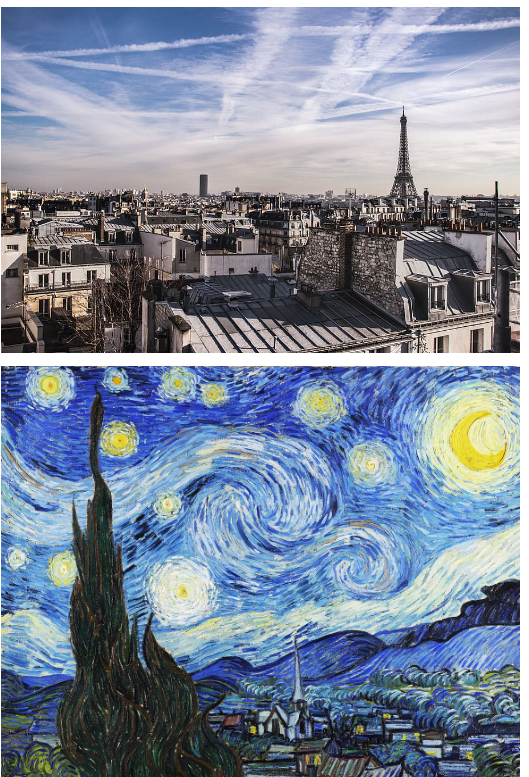

#oraz wynik działania kodu dla total_variation_weight = 1e-6 style_weight = 1e-6 content_weight = 2.5e-8
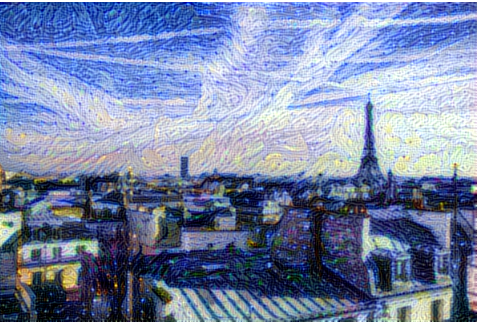

total_variation_weight jest wagą straty całkowitej wariacji, która jest używana do ograniczenia nieregularności obrazu końcowego.

style_weight jest wagą straty stylu, która decyduje o tym, jak mocno styl oryginalnego obrazu zostanie przeniesiony na obraz końcowy.

content_weight jest wagą straty treści, która decyduje o tym, jak mocno treść oryginalnego obrazu zostanie zachowana na obrazie końcowym.

zmieńmy teraz te wartości i sprawdźmy jak to wpłynie na efekt końcowy nowe wartości:
total_variation_weight = 1e-12
style_weight = 1e-6
content_weight = 2.5e-8

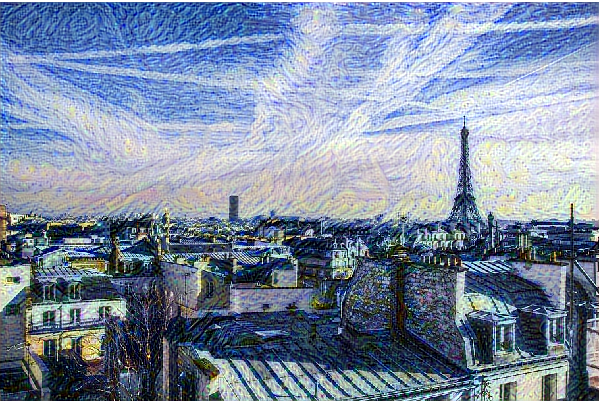

rezlutat 2 obrazów dla total_variation_weight = 1e-12
style_weight = 1e-6
content_weight = 2.5e-8

Przykład działania programu dla innych obrazów
#Użyte obrazy

214018/214018 [==============================] - 0s 0us/step


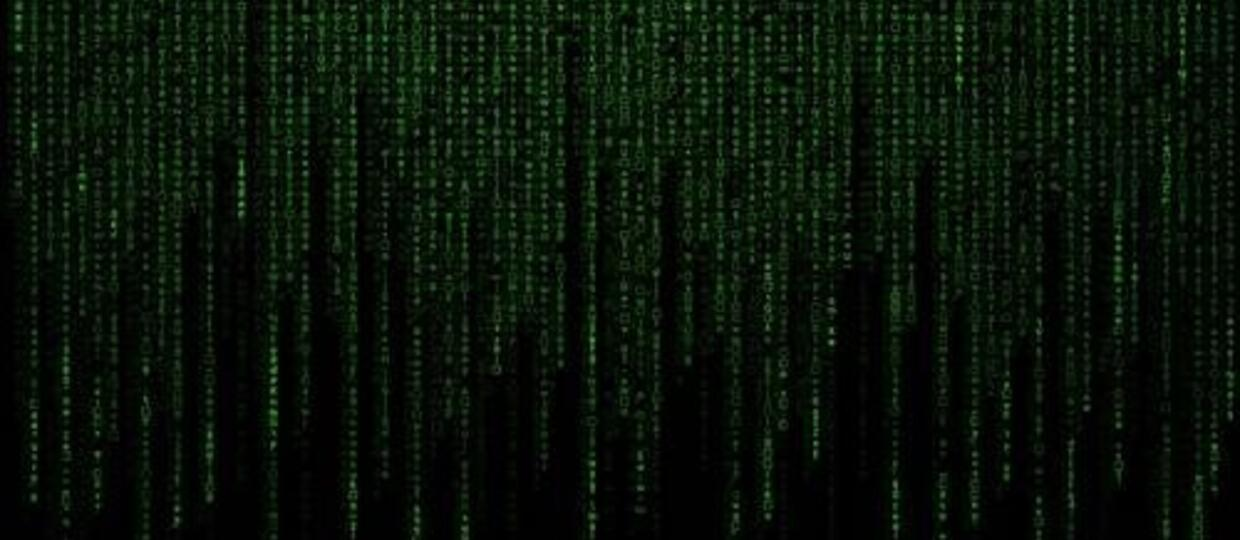

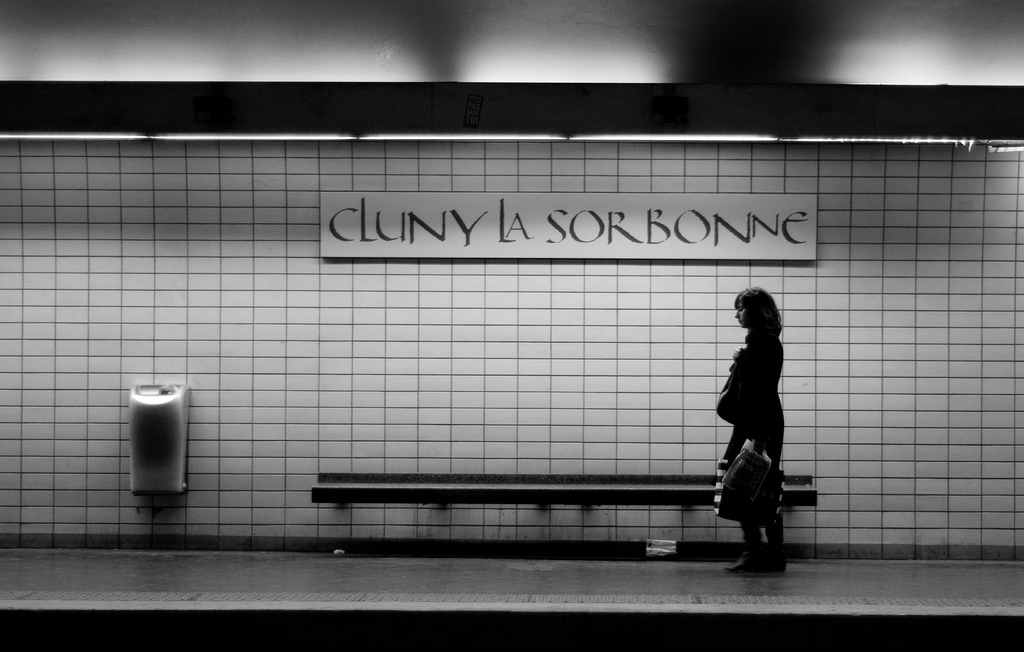

In [2]:
from IPython.display import Image, display
from tensorflow import keras
base_image_path = keras.utils.get_file("paris.jpg", "https://i.imgur.com/2hiV1qG.jpg")
style_reference_image_path = keras.utils.get_file(
    "starry_night.jpg", "https://i.imgur.com/jS5iAbn.jpg"
)

display(Image(base_image_path))
display(Image(style_reference_image_path))

Wynik programu dla poniższych wartości

total_variation_weight = 1e-12
style_weight = 1e-6
content_weight = 2.5e-8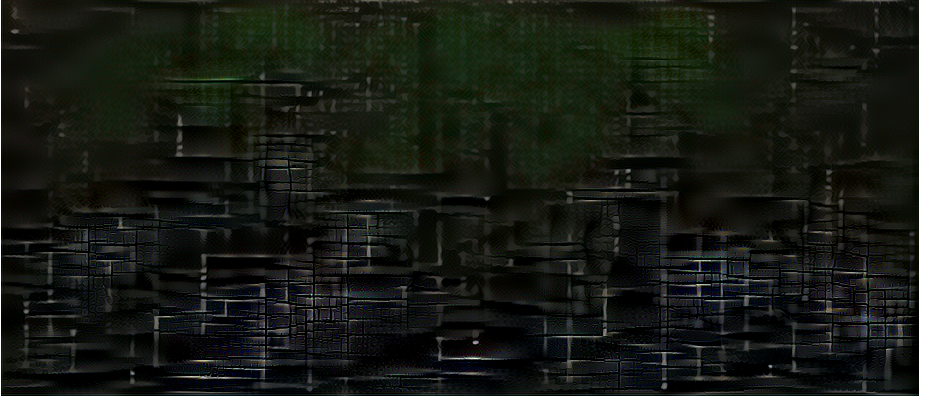

#Kilka słów o VGG19 - modelu warstw sieci wykorzystanym w danym programie
VGG-19 jest siecią konwolucyjną, która jest używana do rozpoznawania obrazów. Kiedy jest wykorzystywana w kodzie, uczy się ją na zbiorze danych i następnie stosują do przetwarzania obrazów.

W kodzie wykorzystywana jest jako architektura sieci, która jest zdefiniowana jako warstwy połączone ze sobą. Modele sieci konwolucyjnej, takie jak VGG-19, składają się z kilku warstw konwolucyjnych, które wykonują filtrowanie obrazów, oraz warstw pełnego połączenia, które analizują i klasyfikują obrazy.

W trakcie uczenia sieci, waga każdej warstwy jest aktualizowana tak, aby jak najlepiej rozpoznawać obrazy. Po uczeniu, sieć jest gotowa do przetwarzania nowych, nieznanych dotąd obrazów.

Wynikiem przetwarzania jest predykcja, czyli klasyfikacja obrazu do jednej z kilku klas.

Wybór warstw sieci VGG-19 może mieć wpływ na jakość wyniku przetwarzania, ponieważ im więcej warstw, tym większa złożoność sieci i potencjalnie lepsze wyniki. Można wybrać inne modele, takie jak ResNet, InceptionNet czy MobileNet, które również są szeroko stosowane w różnych zastosowaniach. Decyzja o wyborze konkretnego modelu zależy od wymagań projektu, takich jak wydajność i wymagania zasobów.

In [2]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications import vgg19

base_image_path = keras.utils.get_file("paris.jpg", "https://i.imgur.com/2hiV1qG.jpg")
style_reference_image_path = keras.utils.get_file(
    "starry_night.jpg", "https://i.imgur.com/jS5iAbn.jpg"
)
result_prefix = "paris_generated"

# Weights of the different loss components
total_variation_weight = 1e-12
style_weight = 1e-6
content_weight = 2.5e-8

# Dimensions of the generated picture.
width, height = keras.preprocessing.image.load_img(base_image_path).size
img_nrows = 400
img_ncols = int(width * img_nrows / height)

214018/214018 [==============================] - 0s 0us/step


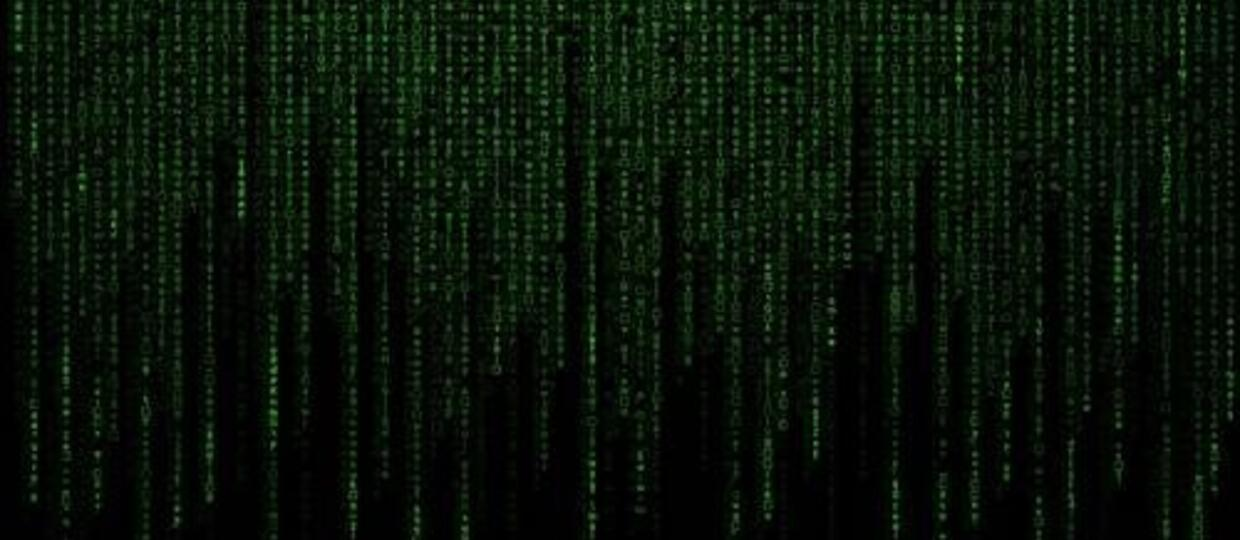

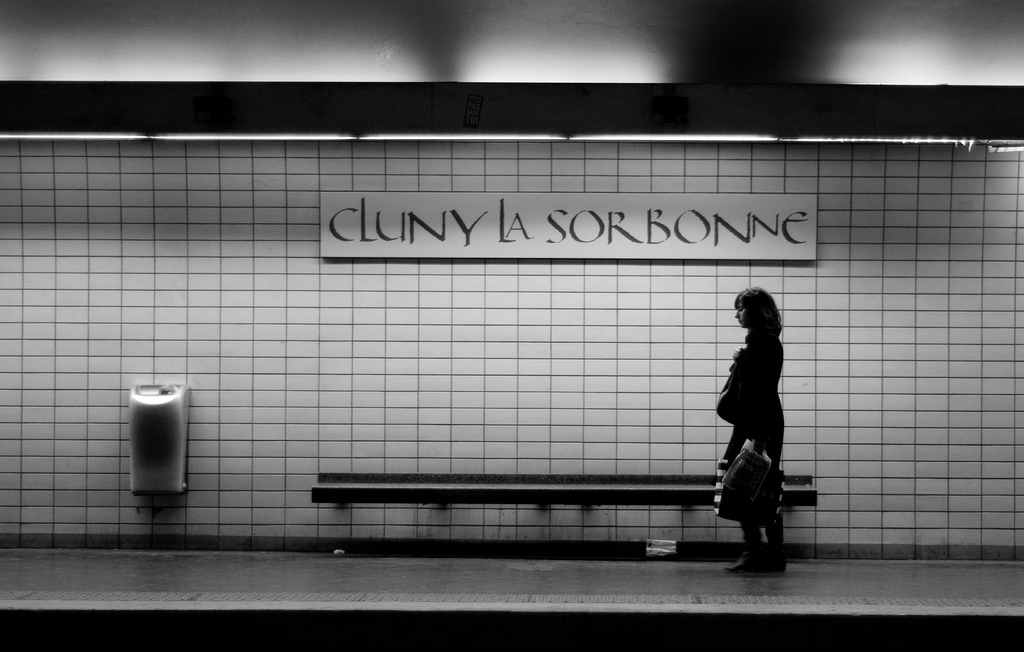

In [3]:
from IPython.display import Image, display

display(Image(base_image_path))
display(Image(style_reference_image_path))

In [4]:
def preprocess_image(image_path):
    # Util function to open, resize and format pictures into appropriate tensors
    img = keras.preprocessing.image.load_img(
        image_path, target_size=(img_nrows, img_ncols)
    )
    img = keras.preprocessing.image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = vgg19.preprocess_input(img)
    return tf.convert_to_tensor(img)


def deprocess_image(x):
    # Util function to convert a tensor into a valid image
    x = x.reshape((img_nrows, img_ncols, 3))
    # Remove zero-center by mean pixel
    x[:, :, 0] += 103.939
    x[:, :, 1] += 116.779
    x[:, :, 2] += 123.68
    # 'BGR'->'RGB'
    x = x[:, :, ::-1]
    x = np.clip(x, 0, 255).astype("uint8")
    return x

In [5]:
# The gram matrix of an image tensor (feature-wise outer product)


def gram_matrix(x):
    x = tf.transpose(x, (2, 0, 1))
    features = tf.reshape(x, (tf.shape(x)[0], -1))
    gram = tf.matmul(features, tf.transpose(features))
    return gram


# The "style loss" is designed to maintain
# the style of the reference image in the generated image.
# It is based on the gram matrices (which capture style) of
# feature maps from the style reference image
# and from the generated image


def style_loss(style, combination):
    S = gram_matrix(style)
    C = gram_matrix(combination)
    channels = 3
    size = img_nrows * img_ncols
    return tf.reduce_sum(tf.square(S - C)) / (4.0 * (channels**2) * (size**2))


# An auxiliary loss function
# designed to maintain the "content" of the
# base image in the generated image


def content_loss(base, combination):
    return tf.reduce_sum(tf.square(combination - base))


# The 3rd loss function, total variation loss,
# designed to keep the generated image locally coherent


def total_variation_loss(x):
    a = tf.square(
        x[:, : img_nrows - 1, : img_ncols - 1, :] - x[:, 1:, : img_ncols - 1, :]
    )
    b = tf.square(
        x[:, : img_nrows - 1, : img_ncols - 1, :] - x[:, : img_nrows - 1, 1:, :]
    )
    return tf.reduce_sum(tf.pow(a + b, 1.25))

In [6]:
# Build a VGG19 model loaded with pre-trained ImageNet weights
model = vgg19.VGG19(weights="imagenet", include_top=False)

# Get the symbolic outputs of each "key" layer (we gave them unique names).
outputs_dict = dict([(layer.name, layer.output) for layer in model.layers])

# Set up a model that returns the activation values for every layer in
# VGG19 (as a dict).
feature_extractor = keras.Model(inputs=model.inputs, outputs=outputs_dict)

80134624/80134624 [==============================] - 3s 0us/step


In [8]:
# List of layers to use for the style loss.
style_layer_names = [
    "block1_conv1",
    "block2_conv1",
    "block3_conv1",
    "block4_conv1",
    "block5_conv1",
]
# The layer to use for the content loss.
content_layer_name = "block5_conv2"


def compute_loss(combination_image, base_image, style_reference_image):
    input_tensor = tf.concat(
        [base_image, style_reference_image, combination_image], axis=0
    )
    features = feature_extractor(input_tensor)

    # Initialize the loss
    loss = tf.zeros(shape=())

    # Add content loss
    layer_features = features[content_layer_name]
    base_image_features = layer_features[0, :, :, :]
    combination_features = layer_features[2, :, :, :]
    loss = loss + content_weight * content_loss(
        base_image_features, combination_features
    )
    # Add style loss
    for layer_name in style_layer_names:
        layer_features = features[layer_name]
        style_reference_features = layer_features[1, :, :, :]
        combination_features = layer_features[2, :, :, :]
        sl = style_loss(style_reference_features, combination_features)
        loss += (style_weight / len(style_layer_names)) * sl

    # Add total variation loss
    loss += total_variation_weight * total_variation_loss(combination_image)
    return loss

In [9]:
@tf.function
def compute_loss_and_grads(combination_image, base_image, style_reference_image):
    with tf.GradientTape() as tape:
        loss = compute_loss(combination_image, base_image, style_reference_image)
    grads = tape.gradient(loss, combination_image)
    return loss, grads

In [10]:
optimizer = keras.optimizers.SGD(
    keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=100.0, decay_steps=100, decay_rate=0.96
    )
)

base_image = preprocess_image(base_image_path)
style_reference_image = preprocess_image(style_reference_image_path)
combination_image = tf.Variable(preprocess_image(base_image_path))

iterations = 4000
for i in range(1, iterations + 1):
    loss, grads = compute_loss_and_grads(
        combination_image, base_image, style_reference_image
    )
    optimizer.apply_gradients([(grads, combination_image)])
    if i % 100 == 0:
        print("Iteration %d: loss=%.2f" % (i, loss))
        img = deprocess_image(combination_image.numpy())
        fname = result_prefix + "_at_iteration_%d.png" % i
        keras.preprocessing.image.save_img(fname, img)

Iteration 100: loss=5167.49
Iteration 200: loss=3847.02
Iteration 300: loss=3240.88
Iteration 400: loss=2861.97
Iteration 500: loss=2593.89
Iteration 600: loss=2391.78
Iteration 700: loss=2233.13
Iteration 800: loss=2104.92
Iteration 900: loss=1998.05
Iteration 1000: loss=1907.49
Iteration 1100: loss=1830.15
Iteration 1200: loss=1763.23
Iteration 1300: loss=1704.78
Iteration 1400: loss=1652.91
Iteration 1500: loss=1606.92
Iteration 1600: loss=1566.24
Iteration 1700: loss=1529.67
Iteration 1800: loss=1496.59
Iteration 1900: loss=1466.65
Iteration 2000: loss=1439.33
Iteration 2100: loss=1414.20
Iteration 2200: loss=1391.18
Iteration 2300: loss=1370.05
Iteration 2400: loss=1350.60
Iteration 2500: loss=1332.59
Iteration 2600: loss=1315.95
Iteration 2700: loss=1300.54
Iteration 2800: loss=1286.23
Iteration 2900: loss=1272.88
Iteration 3000: loss=1260.45
Iteration 3100: loss=1248.85
Iteration 3200: loss=1238.07
Iteration 3300: loss=1227.94
Iteration 3400: loss=1218.43
Iteration 3500: loss=12

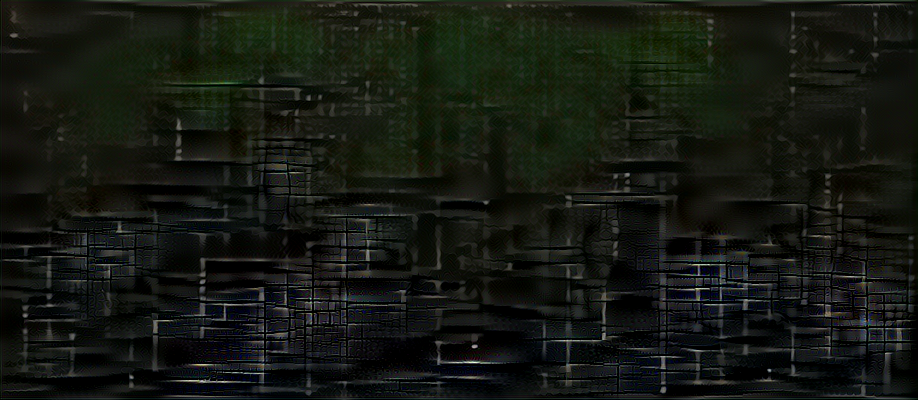

In [11]:
display(Image(result_prefix + "_at_iteration_4000.png"))